# Summarize Dialogue

The first step towards prompt engineering and see how it can enhance the generative output of Large Language Models by comparing **zero shot**, **one shot**, and **few shot** inferences.


In [1]:
!pip install datasets

Load the datasets, Large Language Model (LLM), tokenizer, and configurator.

In [4]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

In [5]:
hf_dataset_name = "knkarthick/dialogsum"
dataset = load_dataset(hf_dataset_name)

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [6]:
dataset # 'summary' is human summary

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [9]:
model_name = 'google/flan-t5-base'
# AutoModel: load the model by its name
# ForSeq2Seq: for seq_to_seq task
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

**Tokenization** is the process of splitting texts into smaller units that can be processed by the LLM models.

`AutoTokenizer.from_pretrained()` method downloads the **tokenizer** for the **corresponding model**. Parameter `use_fast` switches on fast tokenizer.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Test the tokenizer **encoding** and **decoding** a simple sentence.


The output of `tokenizer` is a **dictionary** containing tensors needed for a model: `input_ids` and `attention_mask`.

**input_ids**

- *Type*: **torch.Tensor** (because return_tensors='pt')
- *Contents*: A sequence of **token IDs** corresponding to your prompt.
- *Purpose*: These IDs are the **actual numerical representations** the model uses as input.

`prompt (text)  → tokenizer → input_ids (numbers) → model`

In [29]:
sentence = "Learning Large Language Models (LLMs) is amazing!"

# return_tensors: define the type of the data structure
# pt: pyTorch (& tf: tensorflow)
sentence_encoded = tokenizer(sentence, return_tensors='pt')

print(f'ENCODED: {sentence_encoded}')

ENCODED: {'input_ids': tensor([[ 6630,  7199, 10509,  5154,     7,    41, 10376,   329,     7,    61,
            19,  1237,    55,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [16]:
print(f'ENCODED: {sentence_encoded["input_ids"][0]}')

ENCODED: tensor([ 6630,  7199, 10509,  5154,     7,    41, 10376,   329,     7,    61,
           19,  1237,    55,     1])


`skip_special_tokens=True` removes **special** tokens (e.g., **</s>** which is the *end of sentence* token).


In [20]:
sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0],
        skip_special_tokens=True
    )

print(f'DECODED: {sentence_decoded}')

DECODED: Learning Large Language Models (LLMs) is amazing!


# **0-Summarization without Prompt Engineering**

**Prompt engineering** is an act of a human changing the prompt to improve the response for a given task.

In [71]:
# test on a dialogue (index=200) in the test set
dialogue = dataset['test'][200]['dialogue']
summary = dataset['test'][200]['summary']

inputs = tokenizer(dialogue, return_tensors='pt')

# try to get a summary JUST by limmiting the max_new_tokens
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50
    )[0],
    skip_special_tokens=True
)

print(f'Dialogue: \n{dialogue}\n')

# the model was not asked for summarization => the output will no be a summary!
print(f'Generated Summary: {output}\n')

print(f'Human Summary: {summary}')

Dialogue: 
#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Generated Summary: #Person1#: I'm thinking of upgrading my computer.

Human Summary: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.


# **1-Summarization with an Instruction Prompt**

**Prompt engineering** is an important concept in using foundation models for text generation.

# 1.1-Zero Shot Inference with an Instruction Prompt

Wrap the dialogue in a descriptive instruction.

In [62]:
"""
tokenizer.tgt_lang = "de"   # target language = German
tokenizer.src_lang = "en"   # source language = English

tokenizer.tgt_lang is typically an attribute used in tokenizers for multilingual machine translation models (like mBART, M2M100, NLLB, etc.) to specify the target language you want the model to generate.

It’s not a universal tokenizer attribute — it appears only in certain models where you must set a target language ID before generation.
"""

'\ntokenizer.tgt_lang = "de"   # target language = German\ntokenizer.src_lang = "en"   # source language = English\n\ntokenizer.tgt_lang is typically an attribute used in tokenizers for multilingual machine translation models (like mBART, M2M100, NLLB, etc.) to specify the target language you want the model to generate.\n\nIt’s not a universal tokenizer attribute — it appears only in certain models where you must set a target language ID before generation.\n'

# **1.1.1-Prompt 1**

In [73]:
prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
    """

# Input constructed prompt (instead of the dialogue)
inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
  model.generate(
      inputs["input_ids"],
      max_new_tokens=50,
  )[0],
  skip_special_tokens=True
)

print(f'Dialogue: {dialogue}\n')

print(f'Generated Summary: {output}\n')

print(f'Human Summary: {summary}')

Dialogue: #Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Generated Summary: #Person1#: I'm thinking of upgrading my computer.

Human Summary: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.


# **1.1.2-Prompt 2**

In [64]:
prompt = f"""
Dialogue:

{dialogue}

What was going on?
    """

# Input constructed prompt (instead of the dialogue)
inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
  model.generate(
      inputs["input_ids"],
      max_new_tokens=50,
  )[0],
  skip_special_tokens=True
)

print(f'Dialogue: {dialogue}\n')

print(f'Generated Summary: {output}\n')

print(f'Human Summary: {summary}')

Dialogue: #Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Generated Summary: #Person1#: You could add a painting program to your software. #Person2#: That would be a bonus. #Person1#: You might also want to upgrade your hardware. #Person1#

Human Summary: #Person1# teaches #Pers

# 1.2-One Shot Inference with an Instruction Prompt

In [65]:
def make_prompt(example_indices_full, example_index_to_summarize):
  prompt = ''

  for index in example_indices_full:
    dialogue = dataset['test'][index]['dialogue']
    summary = dataset['test'][index]['summary']

    # The stop sequence '{summary}\n\n\n' is important for FLAN-T5.
    # Other models may have their own preferred stop sequence.
    prompt += f"""
Dialogue:

{dialogue}

What was going on?
{summary}\n\n\n
"""

  dialogue = dataset['test'][example_index_to_summarize]['dialogue']

  prompt += f"""
Dialogue:

{dialogue}

What was going on?
"""

  return prompt

Construct the prompt to perform one shot inference:

In [66]:
example_indices_full = [400] # use as the example
example_index_to_summarize = 200 # use to test the model

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Dialogue:

#Person1#: It was a heavy storm last night, wasn't it?
#Person2#: It certainly was. The wind broke several windows. What weather!
#Person1#: Do you know that big tree in front of my house? One of the biggest branches came down in the night.
#Person2#: Really? Did it do any damage to your home?
#Person1#: Thank goodness! It is far away from that.
#Person2#: I really hate storms. It's about time we had some nice spring weather.
#Person1#: It's April, you know. The flowers are beginning to blossom.
#Person2#: Yes, that's true. But I still think the weather is terrible.
#Person1#: I suppose we should not complain. We had a fine March after all.

What was going on?
#Person1# and #Person2# are talking about the heavy storm last night, and #Person1#'s positive. #Person2# thinks the weather is terrible. #Person1# thinks they should not complain.




Dialogue:

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#

Pass the prompt to perform the one shot inference:

In [67]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)


print(f'Generated Summary: {output}\n')

print(f'Human Summary: {summary}')

Generated Summary: #Person1# wants to upgrade his system. #Person2# wants to add a painting program to his software. #Person1# wants to add a CD-ROM drive.

Human Summary: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.


# 1.3-Few Shot Inference

In [69]:
example_indices_full = [40, 80, 120]
example_index_to_summarize = 200

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

Pass the prompt to perform a few shot inference:

In [74]:
summary = dataset['test'][example_index_to_summarize]['summary']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(f'Generated Summary: {output}\n')

print(f'Human Summary: {summary}')

Generated Summary: #Person1 wants to upgrade his system. #Person2 wants to add a painting program to his software. #Person1 wants to upgrade his hardware.

Human Summary: #Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.


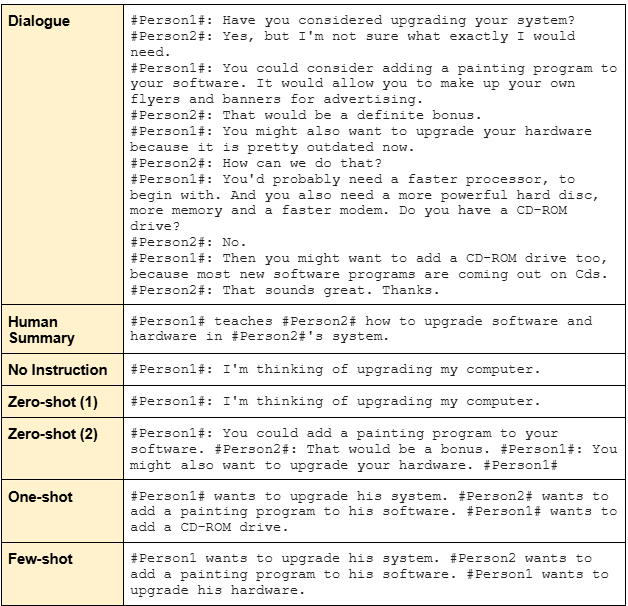